In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from fullfrlm import flow_refueling_location_model
from ema_workbench import IntegerParameter, RealParameter, Model, ScalarOutcome, CategoricalParameter, Constant
import time

C:\Users\Fabia\miniconda3\envs\ox\lib\site-packages\osmnx\utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


In [2]:
## Load necessary data
df_h = pickle.load(open("data/revised_cleaning_results/harbour_data_100.p", "rb"))
df_ivs = pickle.load(open("data/revised_cleaning_results/ivs_exploded_100.p", "rb"))
path_lengths = pickle.load(open("data/revised_cleaning_results/path_lengths_ship_specific_routes.p", "rb"))
G = pickle.load(open('data/network_cleaned_final.p', 'rb'))
paths = pickle.load(open("data/final_paths.p", "rb"))

In [4]:
%%time
r=60000
v=15000
p_b=175
stations_to_place = 40
station_cap = 600
max_per_loc = 2

total_flow, fraction_captured_total, serviceable_fraction, served_fraction, routes_supported = flow_refueling_location_model(r, v, p_b, stations_to_place, station_cap, max_per_loc, load=1, seed=None,
                                  random_data=False, additional_nodes=False, include_intersections=False)

Optimal
CPU times: total: 1.75 s
Wall time: 1.9 s


In [4]:
total_flow

1260.257925636008

In [5]:
fraction_captured_total

0.1879923315688458

In [ ]:
serviceable_fraction

In [7]:
served_fraction

0.7168334859375228

In [8]:
routes_supported

29.0

## Works, now connect to workbench

### First run with non-random data

In [2]:
#define model
model = Model("frlm", function=flow_refueling_location_model)

In [3]:
# r, v, p_b, stations_to_place, station_cap, max_per_loc, load=1, seed=None,
#                                   random_data=False, additional_nodes=False, include_intersections=False

In [4]:
model.uncertainties = [
    RealParameter("r", 40000, 150000),
]

# set levers
model.levers = [
    IntegerParameter("stations_to_place", 10, 100),
    IntegerParameter("station_cap", 500, 2500),
    CategoricalParameter("max_per_loc", [1, 2, 3]),
    IntegerParameter("v", 10, 20),
    IntegerParameter("p_b", 150, 300),
    # CategoricalParameter("additional_nodes", [0, 30, 60]),
]

# specify outcomes
model.outcomes = [
    ScalarOutcome("total_flow"),
    ScalarOutcome("fraction_captured_total"),
    ScalarOutcome("serveable_fraction"),
    ScalarOutcome("served_fraction"),
    ScalarOutcome("routes_supported"),
]

model.constants = [
    Constant("random_data", True),
]

In [5]:
from ema_workbench import MultiprocessingEvaluator, SequentialEvaluator, ema_logging, perform_experiments

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model, n_processes=20) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=100, policies=100)

[MainProcess/INFO] pool started with 20 workers
[MainProcess/INFO] performing 100 scenarios * 100 policies * 1 model(s) = 10000 experiments
100%|██████████████████████████████████| 10000/10000 [2:57:12<00:00,  1.06s/it]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [8]:
experiments

r max_per_loc    p_b  station_cap  stations_to_place     v  \
0      64440.290709           1  274.0       1133.0               33.0  13.0   
1      85575.671678           1  274.0       1133.0               33.0  13.0   
2     141357.783778           1  274.0       1133.0               33.0  13.0   
3     125969.292326           1  274.0       1133.0               33.0  13.0   
4     108867.224301           1  274.0       1133.0               33.0  13.0   
...             ...         ...    ...          ...                ...   ...   
9995   54275.075829           1  214.0       2455.0               55.0  11.0   
9996  144644.107844           1  214.0       2455.0               55.0  11.0   
9997   70616.867865           1  214.0       2455.0               55.0  11.0   
9998  119453.710886           1  214.0       2455.0               55.0  11.0   
9999   42966.680529           1  214.0       2455.0               55.0  11.0   

     scenario policy model  
0         100      0  frlm  
1         101      0  frlm  
2         102      0  frlm  
3         103      0  frlm  
4         104      0  frlm  
...       ...    ...   ...  
9995      195     99  frlm  
9996      196     99  frlm  
9997      197     99  frlm  
9998      198     99  frlm  
9999      199     99  frlm  

[10000 rows x 9 columns]

In [6]:
pickle.dump( experiments, open( "results/experiments_new100100random.p", "wb" ) )
pickle.dump( outcomes, open("results/outcomes_new100100random.p", "wb") )
# experiments = pickle.load( open("results/experiments_full100100.p", "rb"))
# outcomes = pickle.load( open("results/outcomes_full100100.p", "rb"))

## Run model for 300 and 10 policies without changing station cap and max per loc

In [9]:
experiments

r max_per_loc    p_b  station_cap  stations_to_place     v  \
0   138449.249837           1  181.0       1854.0               50.0  19.0   
1    70716.315931           1  181.0       1854.0               50.0  19.0   
2    47377.422701           1  181.0       1854.0               50.0  19.0   
3   127538.033779           1  181.0       1854.0               50.0  19.0   
4   100127.925251           1  181.0       1854.0               50.0  19.0   
5   138449.249837           2  169.0       2428.0               78.0  15.0   
6    70716.315931           2  169.0       2428.0               78.0  15.0   
7    47377.422701           2  169.0       2428.0               78.0  15.0   
8   127538.033779           2  169.0       2428.0               78.0  15.0   
9   100127.925251           2  169.0       2428.0               78.0  15.0   
10  138449.249837           3  193.0        874.0               21.0  12.0   
11   70716.315931           3  193.0        874.0               21.0  12.0   
12   47377.422701           3  193.0        874.0               21.0  12.0   
13  127538.033779           3  193.0        874.0               21.0  12.0   
14  100127.925251           3  193.0        874.0               21.0  12.0   
15  138449.249837           2  158.0       1498.0               59.0  13.0   
16   70716.315931           2  158.0       1498.0               59.0  13.0   
17   47377.422701           2  158.0       1498.0               59.0  13.0   
18  127538.033779           2  158.0       1498.0               59.0  13.0   
19  100127.925251           2  158.0       1498.0               59.0  13.0   

   scenario policy model  
0         4      0  frlm  
1         5      0  frlm  
2         6      0  frlm  
3         7      0  frlm  
4         8      0  frlm  
5         4      1  frlm  
6         5      1  frlm  
7         6      1  frlm  
8         7      1  frlm  
9         8      1  frlm  
10        4      2  frlm  
11        5      2  frlm  
12        6      2  frlm  
13        7      2  frlm  
14        8      2  frlm  
15        4      3  frlm  
16        5      3  frlm  
17        6      3  frlm  
18        7      3  frlm  
19        8      3  frlm

## Visualize results for each policy in a pairplot

In [15]:
policies = experiments["policy"]
for i, policy in enumerate(np.unique(policies)):
    experiments.loc[policies == policy, "policy"] = str(i)

data = pd.DataFrame(outcomes)
data["policy"] = policies

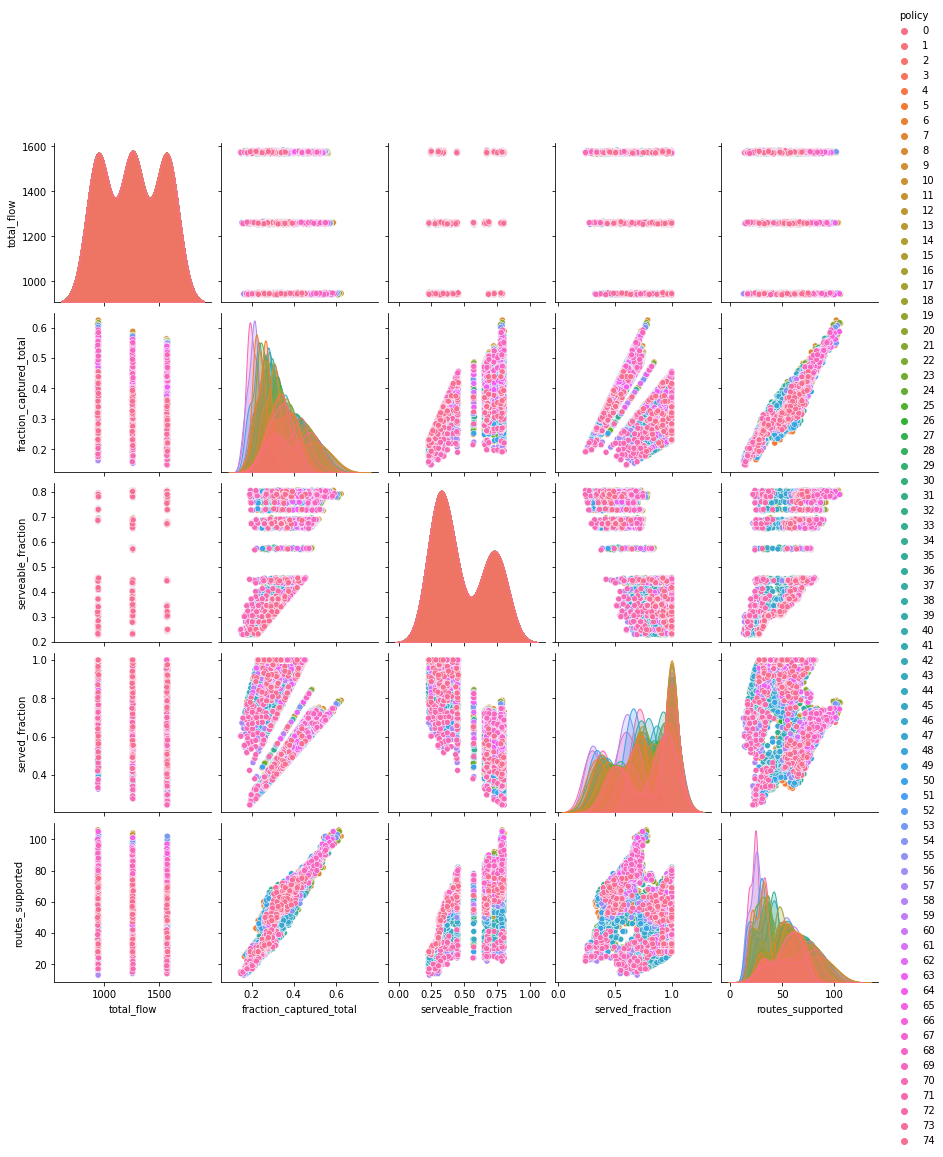

In [16]:
sns.pairplot(data, hue="policy", vars=list(outcomes.keys()))
plt.show()

## "Normal" pairplot?

In [17]:
all_data = experiments.copy()
all_data['total_flow'] = outcomes['total_flow']
all_data['fraction_captured_total'] = outcomes['fraction_captured_total']
all_data['serveable_fraction'] = outcomes['serveable_fraction']
all_data['served_fraction'] = outcomes['served_fraction']
all_data['routes_supported'] = outcomes['routes_supported']

In [18]:
all_data

load              r max_per_loc  station_cap  stations_to_place  \
0        1  101786.256226           1       2290.0               32.0   
1     0.75   78389.823924           1       2290.0               32.0   
2        1   64882.880395           1       2290.0               32.0   
3        1   92446.524901           1       2290.0               32.0   
4     0.75  142915.643382           1       2290.0               32.0   
...    ...            ...         ...          ...                ...   
5620  0.75  137742.389748           1       2259.0               38.0   
5621     1   88979.731236           1       2259.0               38.0   
5622  1.25   60307.911141           1       2259.0               38.0   
5623     1   42560.497090           1       2259.0               38.0   
5624     1  148223.918919           1       2259.0               38.0   

     scenario policy model   total_flow  fraction_captured_total  \
0          75      0  frlm  1258.226145                 0.371756   
1          76      0  frlm   944.315773                 0.321388   
2          77      0  frlm  1258.217065                 0.305302   
3          78      0  frlm  1262.556712                 0.321261   
4          79      0  frlm   947.133933                 0.458035   
...       ...    ...   ...          ...                      ...   
5620      145     74  frlm   947.728532                 0.438699   
5621      146     74  frlm  1255.223562                 0.326020   
5622      147     74  frlm  1576.659491                 0.279511   
5623      148     74  frlm  1258.537299                 0.231357   
5624      149     74  frlm  1258.324305                 0.393648   

      serveable_fraction  served_fraction  routes_supported  
0               0.443168         0.838861              60.0  
1               0.321388         1.000000              53.0  
2               0.310558         0.983076              45.0  
3               0.368884         0.870899              57.0  
4               0.789988         0.579800              73.0  
...                  ...              ...               ...  
5620            0.780115         0.562352              75.0  
5621            0.371140         0.878428              57.0  
5622            0.303482         0.921015              37.0  
5623            0.231357         1.000000              28.0  
5624            0.800923         0.491494              74.0  

[5625 rows x 13 columns]

In [19]:
# all_data = all_data.loc[:, ['load','r', 'stations_to_place','total_flow','supported_fraction']]

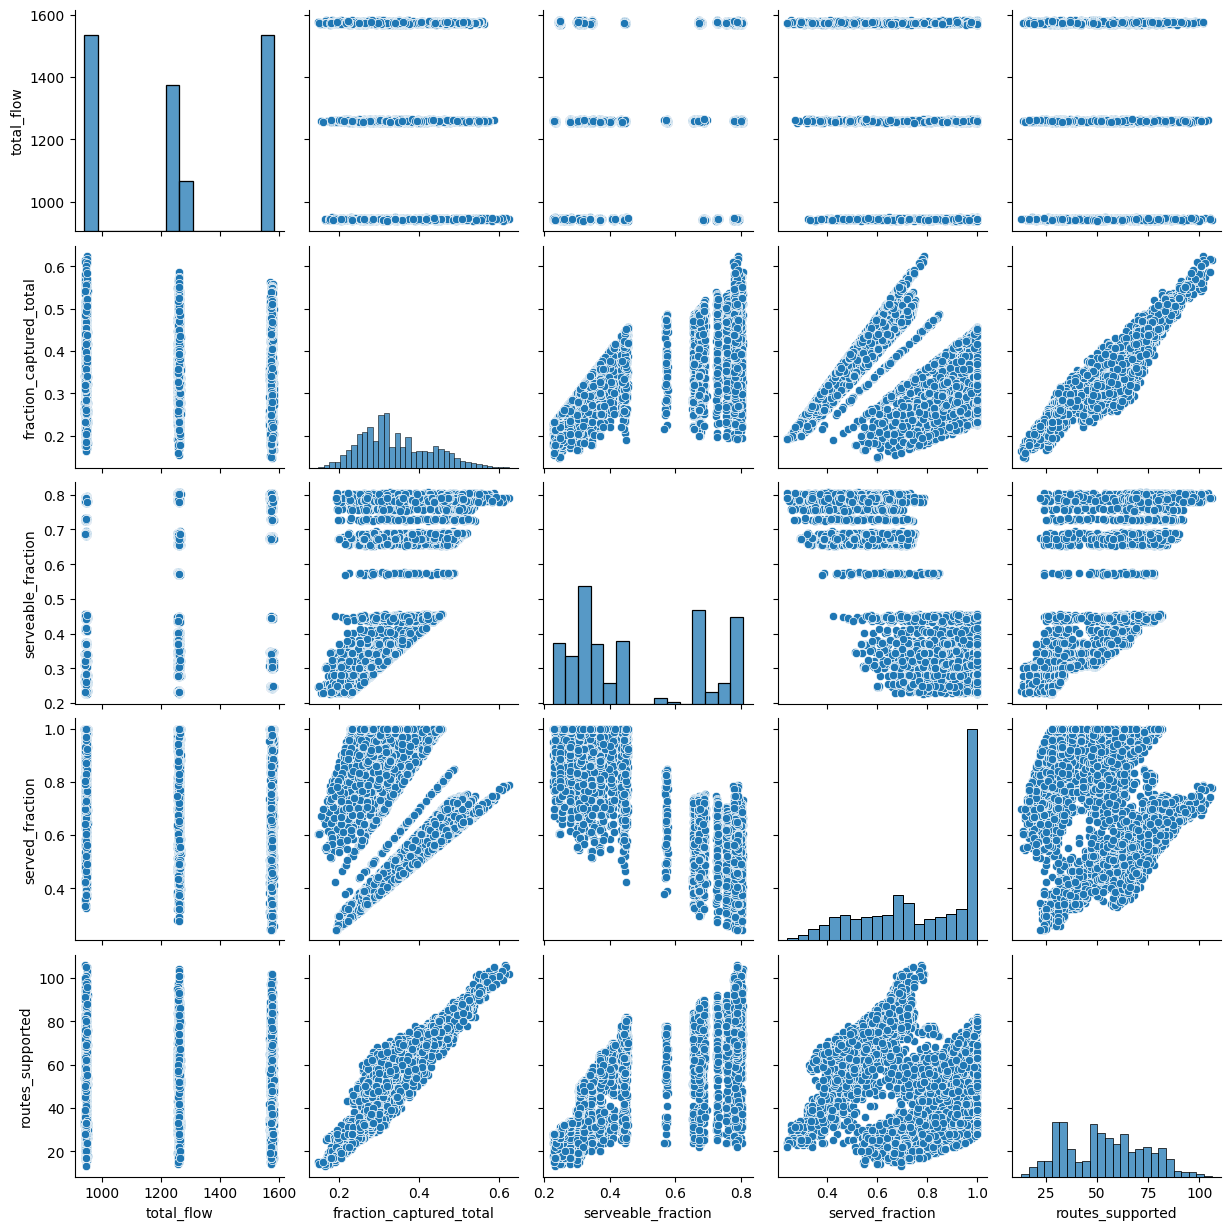

In [20]:
sns.pairplot(all_data, vars=list(outcomes.keys()))

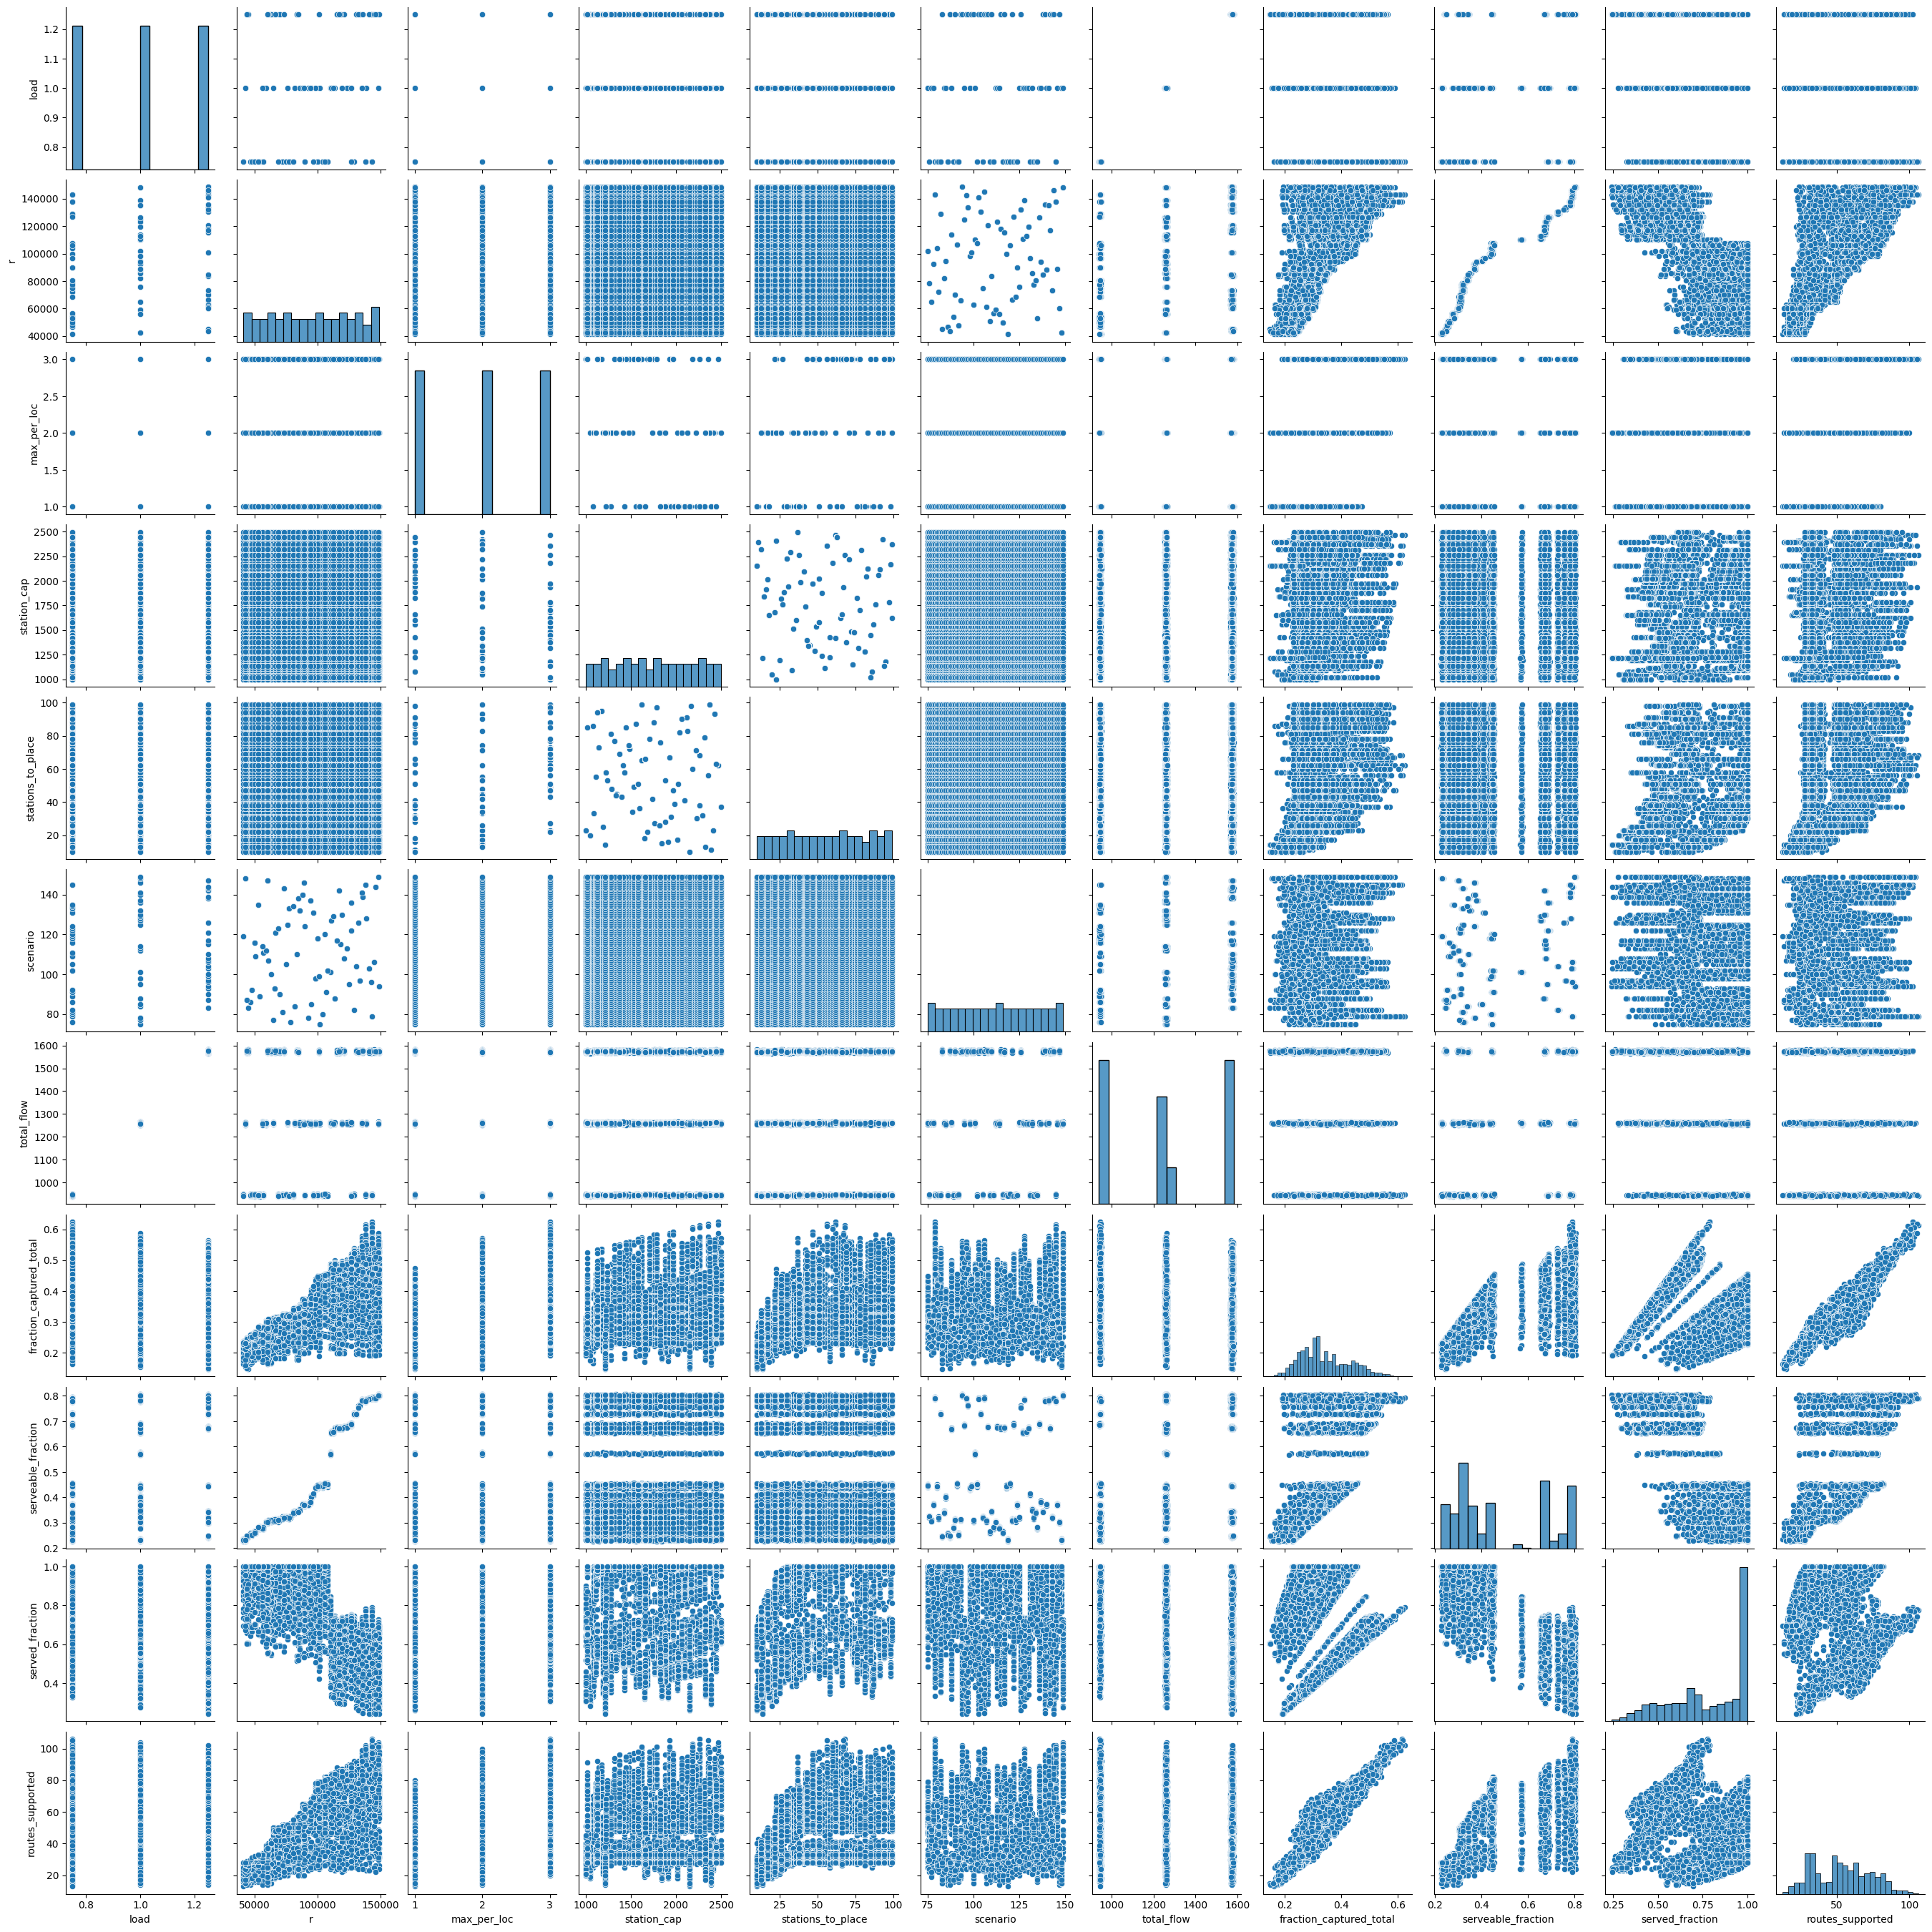

In [21]:
sns.pairplot(all_data)

In [22]:
all_data

load              r max_per_loc  station_cap  stations_to_place  \
0        1  101786.256226           1       2290.0               32.0   
1     0.75   78389.823924           1       2290.0               32.0   
2        1   64882.880395           1       2290.0               32.0   
3        1   92446.524901           1       2290.0               32.0   
4     0.75  142915.643382           1       2290.0               32.0   
...    ...            ...         ...          ...                ...   
5620  0.75  137742.389748           1       2259.0               38.0   
5621     1   88979.731236           1       2259.0               38.0   
5622  1.25   60307.911141           1       2259.0               38.0   
5623     1   42560.497090           1       2259.0               38.0   
5624     1  148223.918919           1       2259.0               38.0   

     scenario policy model   total_flow  fraction_captured_total  \
0          75      0  frlm  1258.226145                 0.371756   
1          76      0  frlm   944.315773                 0.321388   
2          77      0  frlm  1258.217065                 0.305302   
3          78      0  frlm  1262.556712                 0.321261   
4          79      0  frlm   947.133933                 0.458035   
...       ...    ...   ...          ...                      ...   
5620      145     74  frlm   947.728532                 0.438699   
5621      146     74  frlm  1255.223562                 0.326020   
5622      147     74  frlm  1576.659491                 0.279511   
5623      148     74  frlm  1258.537299                 0.231357   
5624      149     74  frlm  1258.324305                 0.393648   

      serveable_fraction  served_fraction  routes_supported  
0               0.443168         0.838861              60.0  
1               0.321388         1.000000              53.0  
2               0.310558         0.983076              45.0  
3               0.368884         0.870899              57.0  
4               0.789988         0.579800              73.0  
...                  ...              ...               ...  
5620            0.780115         0.562352              75.0  
5621            0.371140         0.878428              57.0  
5622            0.303482         0.921015              37.0  
5623            0.231357         1.000000              28.0  
5624            0.800923         0.491494              74.0  

[5625 rows x 13 columns]

In [23]:
# all_data = all_data.loc[:, ['load','r', 'stations_to_place','total_flow','supported_fraction']]

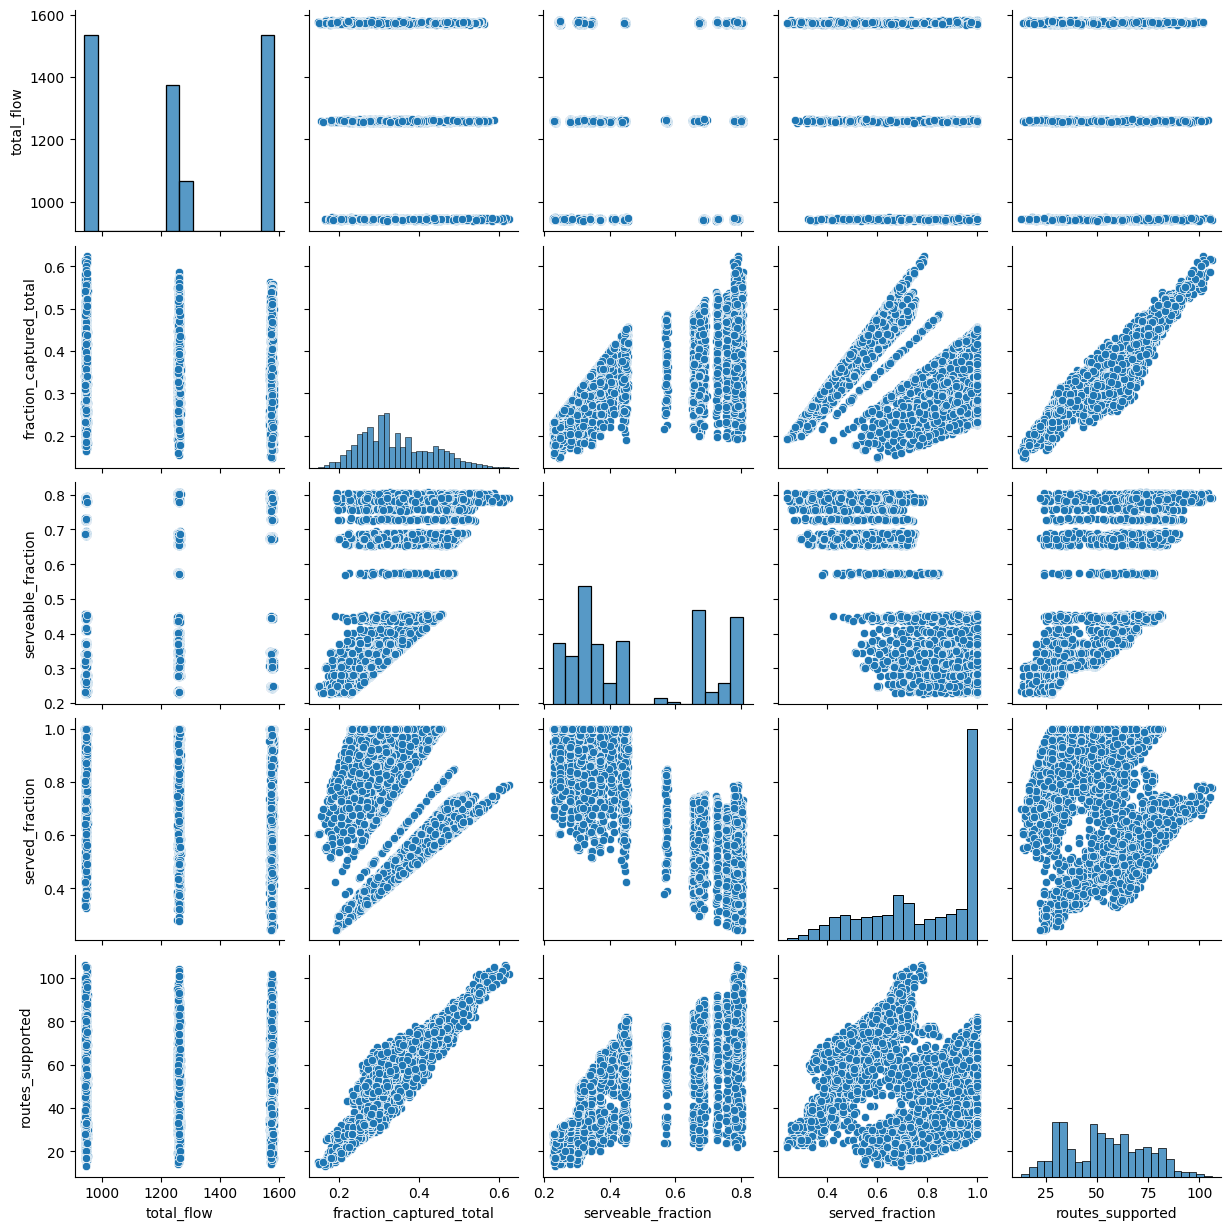

In [24]:
sns.pairplot(all_data, vars=list(outcomes.keys()))

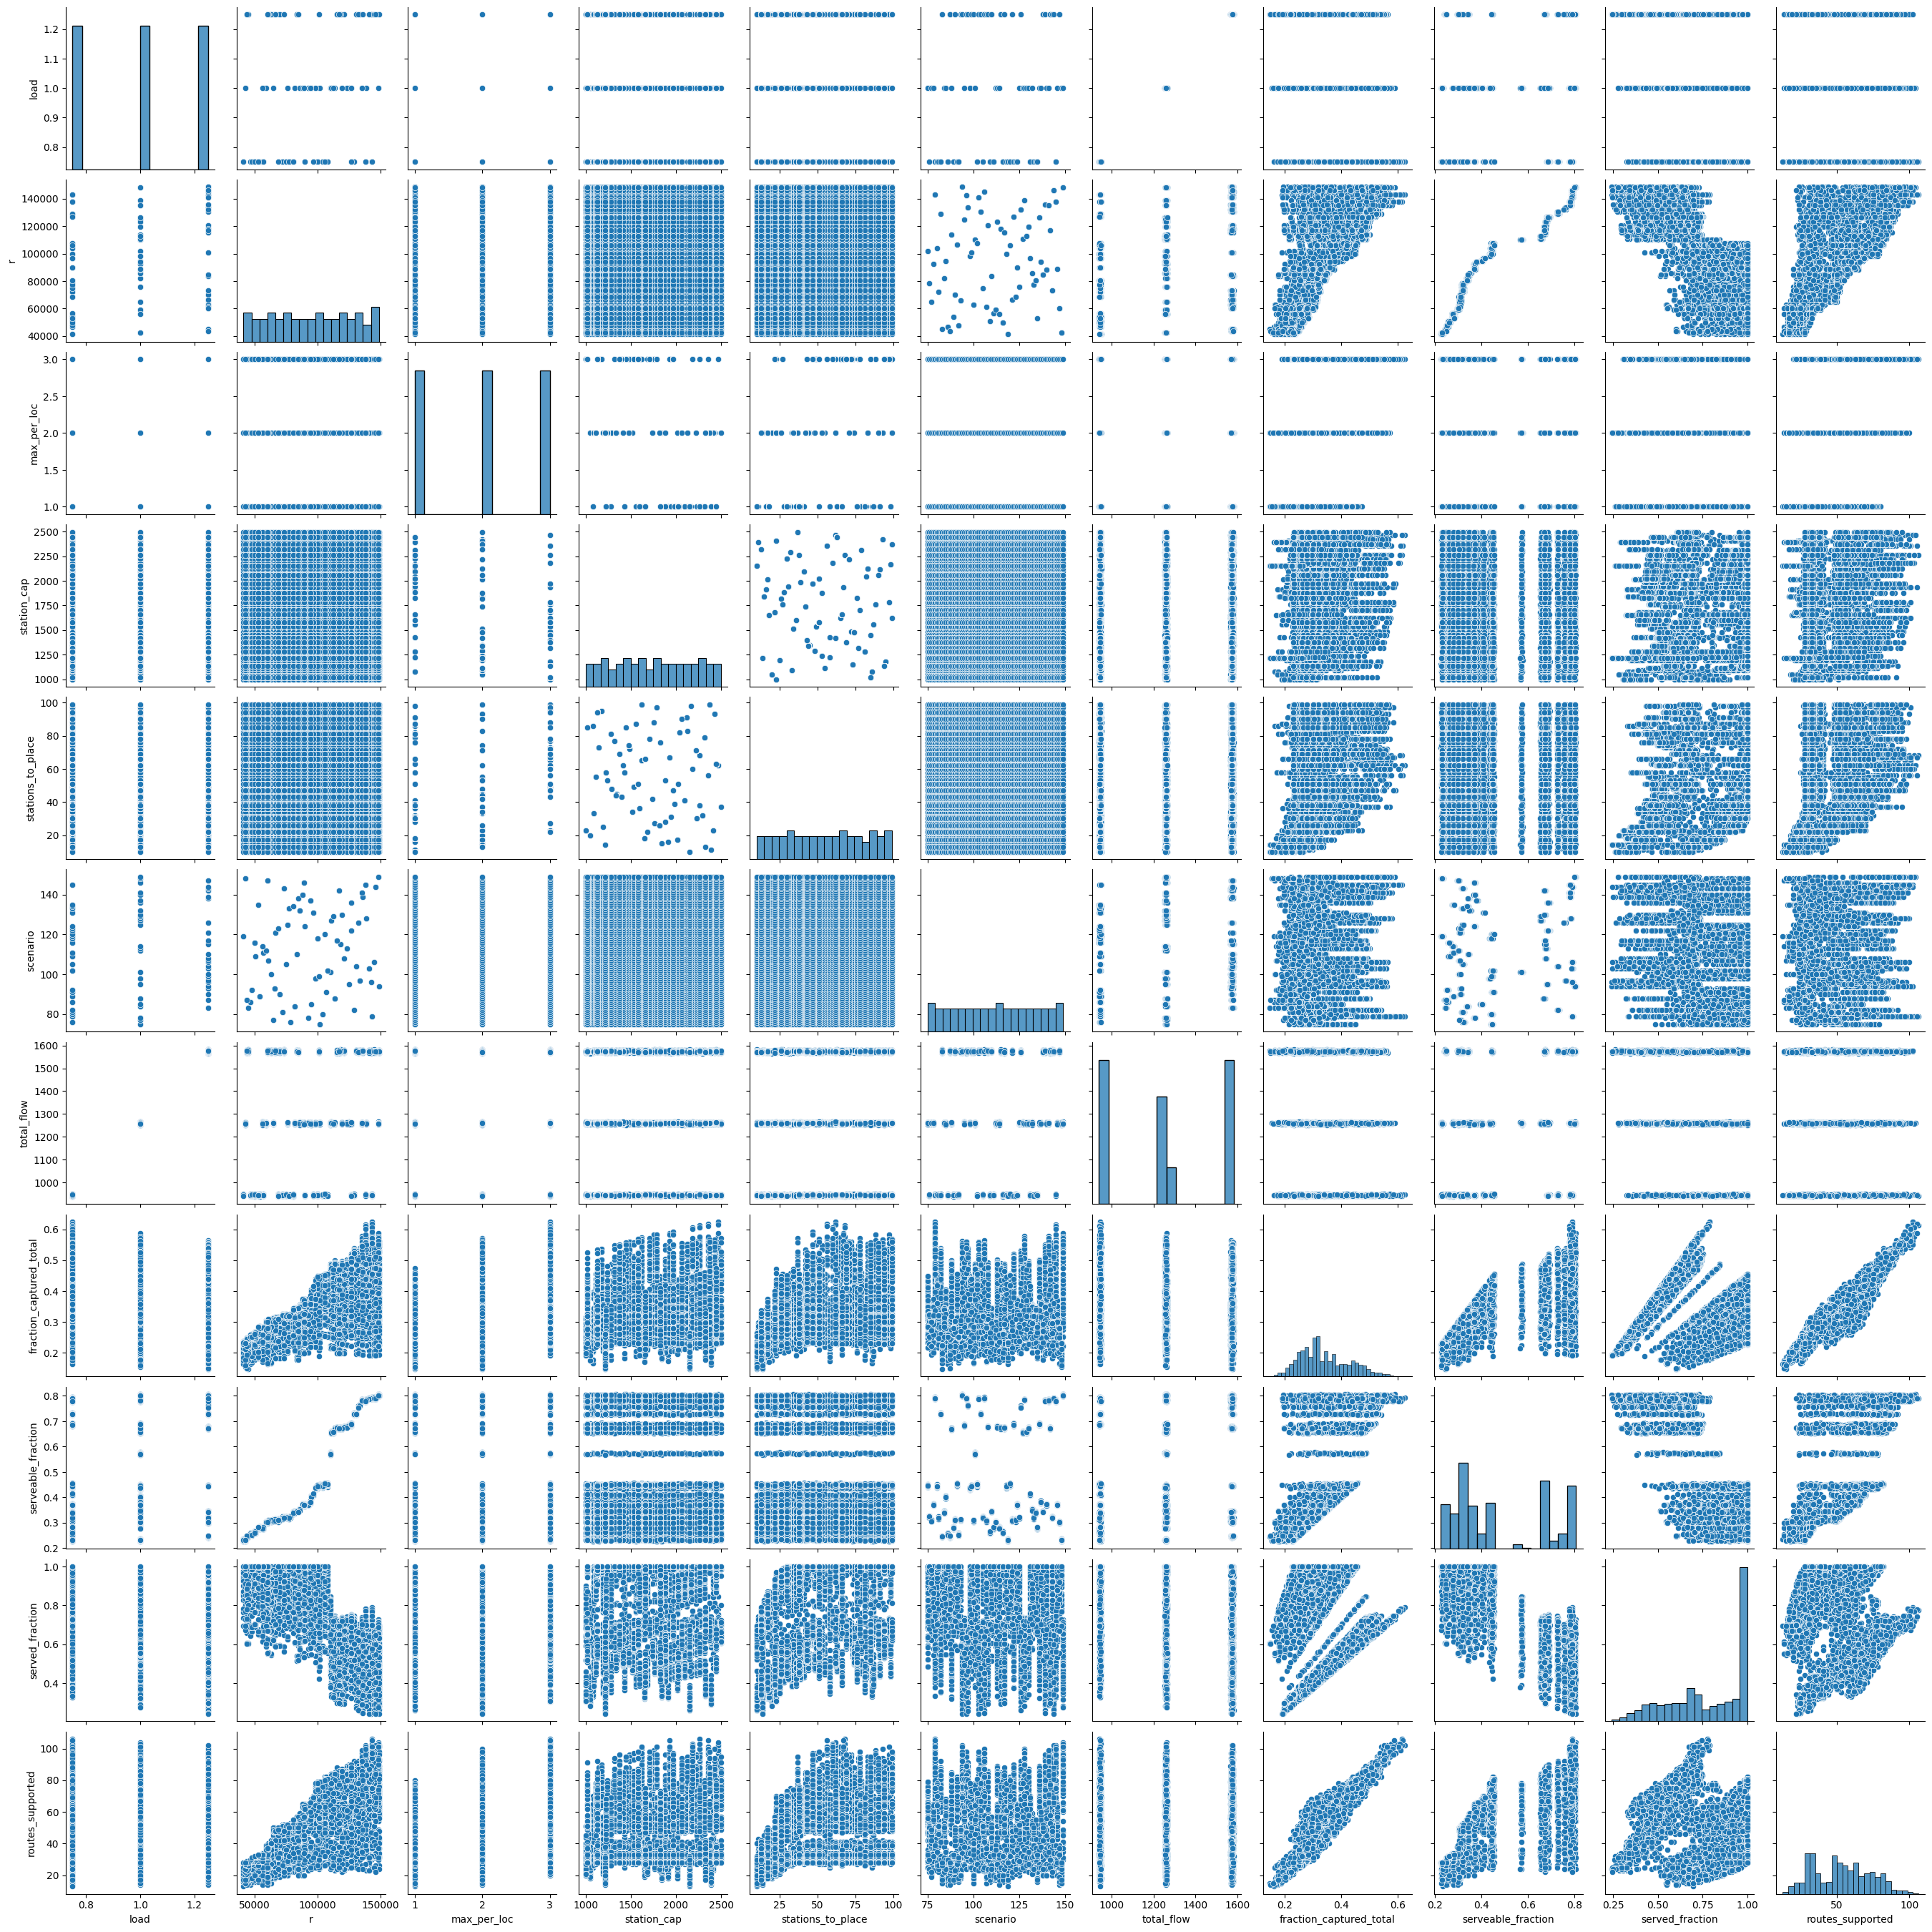

In [25]:
sns.pairplot(all_data)

## Visualize how results are correlated

[MainProcess/INFO] no time dimension found in results


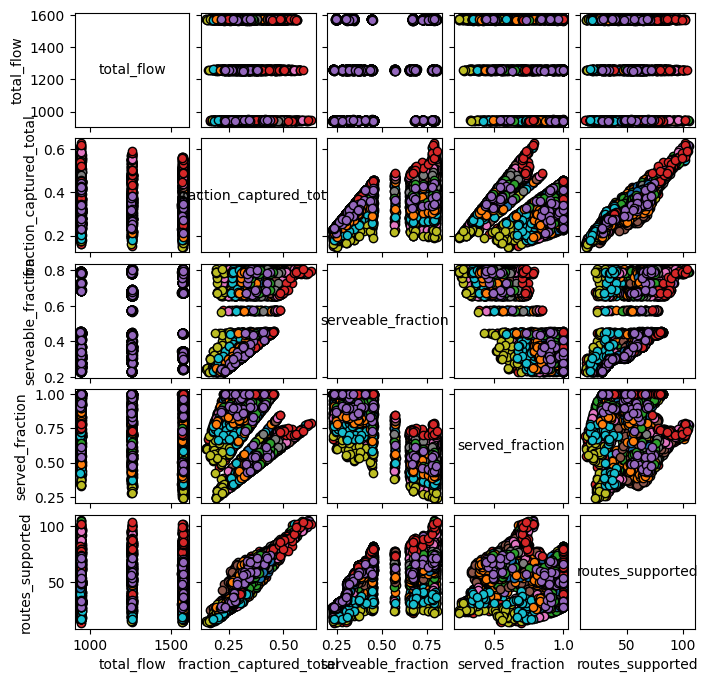

In [30]:
from ema_workbench.analysis import pairs_plotting

fig, axes = pairs_plotting.pairs_scatter(
    experiments, outcomes, group_by="policy", legend=False
)
fig.set_size_inches(8, 8)
plt.show()

In [36]:
from ema_workbench.analysis import prim
%matplotlib inline
x = experiments
y = (1-outcomes["fraction_captured_total"]) < 0.7
prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 5625 points remaining, containing 3620 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.3783111111111111, coverage: 0.5878453038674033, density: 1.0 restricted_dimensions: 2


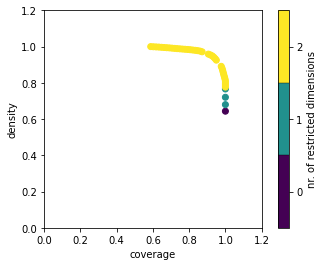

In [37]:
box1.show_tradeoff()
plt.show()

coverage     0.992818
density      0.838936
id          10.000000
mass         0.761600
mean         0.838936
res_dim      2.000000
Name: 10, dtype: float64

                                                   box 10  \
                                                      min   
r                                            57764.002325   
policy  {59, 51, 15, 13, 0, 16, 46, 63, 38, 55, 49, 29...   

                                                           \
                                                      max   
r                                           148600.006134   
policy  {59, 51, 15, 13, 0, 16, 46, 63, 38, 55, 49, 29...   

                                       
                            qp values  
r       [9.792351399193448e-93, -1.0]  
policy  [5.231882297726892e-32, -1.0]  



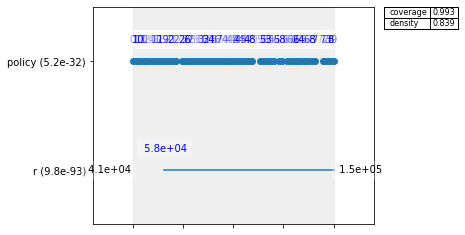

In [38]:
box1.inspect(10)
box1.inspect(10, style="graph")
plt.show()

C:\Users\fpsdriessen\Anaconda3\envs\py310\lib\site-packages\ema_workbench\analysis\scenario_discovery_util.py:419: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


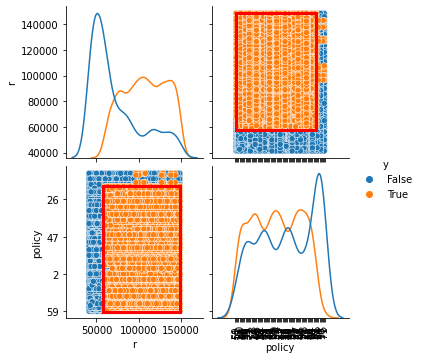

In [39]:
box1.show_pairs_scatter(10)
plt.show()

[MainProcess/INFO] model dropped from analysis because only a single category
C:\Users\Fabia\miniconda3\envs\ox\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
[MainProcess/INFO] model dropped from analysis because only a single category
C:\Users\Fabia\miniconda3\envs\ox\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\Fabia\miniconda3\envs\ox\lib\site-packages\ema_workbench\analysis\feature_scoring.py:389: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete = complete.append(fs.T, sort=True)
[MainProcess/INFO] model dropped from analysis because only a single category
C:\Users\Fabia\m

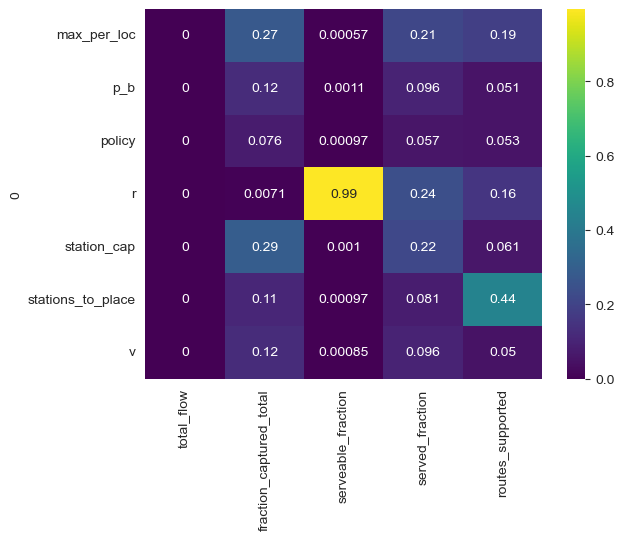

In [12]:
from ema_workbench.analysis import feature_scoring

x = experiments
y = outcomes

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap="viridis", annot=True)
plt.show()

In [16]:
outcomes

{'total_flow': array([1259.29863014, 1259.29863014, 1259.29863014, ..., 1259.29863014,
        1259.29863014, 1259.29863014]),
 'fraction_captured_total': array([0.00067567, 0.00068239, 0.00072475, ..., 0.00165176, 0.00176166,
        0.00134336]),
 'serveable_fraction': array([0.3101215 , 0.35170498, 0.7908983 , ..., 0.32031187, 0.67312641,
        0.24600797]),
 'served_fraction': array([0.00217874, 0.00194022, 0.00091636, ..., 0.00515672, 0.00261713,
        0.00546064]),
 'routes_supported': array([18., 20., 21., ..., 20., 25., 12.])}

In [17]:
fs = feature_scoring.CHI2(x, y)

ValueError: could not convert string to float: 'frlm'

In [13]:
fs

total_flow  fraction_captured_total  serveable_fraction  \
0                                                                            
max_per_loc               0.0                 0.274538            0.000575   
p_b                       0.0                 0.123733            0.001051   
policy                    0.0                 0.075821            0.000968   
r                         0.0                 0.007102            0.994581   
station_cap               0.0                 0.289456            0.001007   
stations_to_place         0.0                 0.107489            0.000970   
v                         0.0                 0.121862            0.000849   

                   served_fraction  routes_supported  
0                                                     
max_per_loc               0.212787          0.186055  
p_b                       0.096400          0.051053  
policy                    0.057050          0.052655  
r                         0.239585          0.155056  
station_cap               0.216671          0.060788  
stations_to_place         0.081044          0.443961  
v                         0.096462          0.050431

[MainProcess/INFO] model dropped from analysis because only a single category


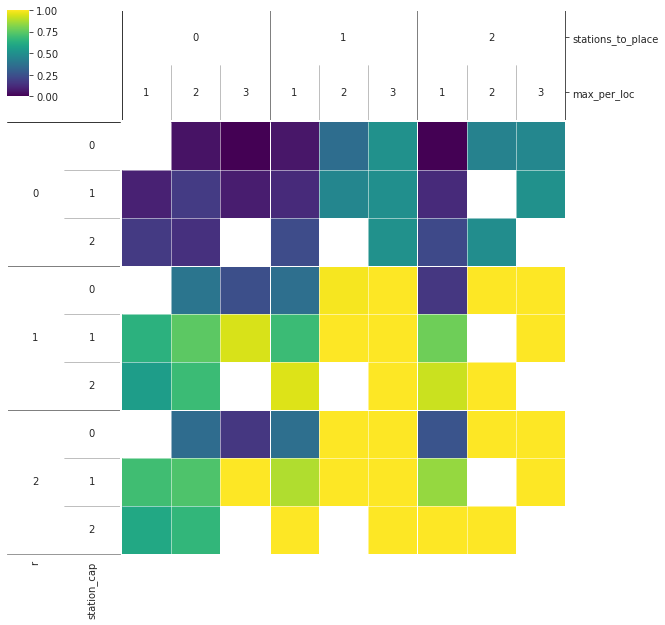

In [42]:
from ema_workbench.analysis import dimensional_stacking

x = experiments
y = (1-outcomes["fraction_captured_total"]) < 0.7
dimensional_stacking.create_pivot_plot(x, y, 2, nbins=3)
plt.show()

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U1'), dtype('float64')) -> None

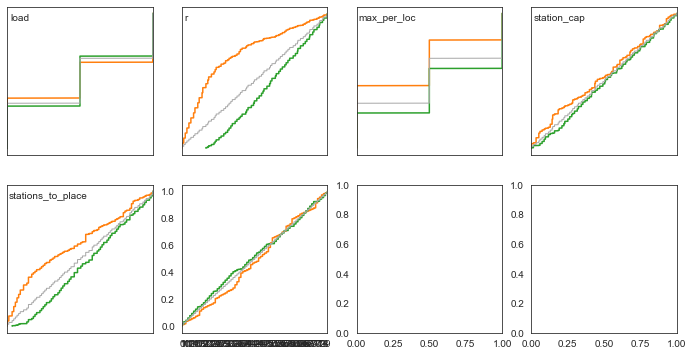

In [44]:
from ema_workbench.analysis import regional_sa
from numpy.lib import recfunctions as rf

sns.set_style("white")

# model is the same across experiments
x = experiments.copy()
x = x.drop("model", axis=1)
y = (1-outcomes["fraction_captured_total"]) < 0.7
fig = regional_sa.plot_cdfs(x, y)
sns.despine()
plt.show()

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U1'), dtype('float64')) -> None

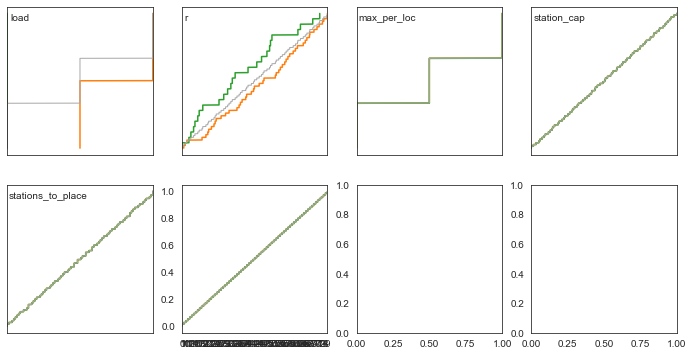

In [45]:
from ema_workbench.analysis import regional_sa
from numpy.lib import recfunctions as rf

sns.set_style("white")

# model is the same across experiments
x = experiments.copy()
x = x.drop("model", axis=1)
y = (outcomes["total_flow"]) < 1000
fig = regional_sa.plot_cdfs(x, y)
sns.despine()
plt.show()

## Sobol sampling

In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from fullfrlm import flow_refueling_location_model

## Load necessary data
G = pickle.load(open('data/cleaned_network.p', 'rb'))
df_h = pickle.load(open("data/harbour_data_100.p", "rb"))
df_ivs = pickle.load(open("data/ivs_exploded_100.p", "rb"))
paths = pickle.load(open("data/paths_ship_specific_routes.p", "rb"))
path_lengths = pickle.load(open("data/path_lengths_ship_specific_routes.p", "rb"))

FileNotFoundError: [Errno 2] No such file or directory: 'data/cleaned_network.p'

In [ ]:
from ema_workbench import MultiprocessingEvaluator, SequentialEvaluator
from SALib.analyze import sobol
from ema_workbench import Samplers, Model
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

model = Model("frlm", function=flow_refueling_location_model)

In [ ]:
from ema_workbench import IntegerParameter, RealParameter, Model, ScalarOutcome, ArrayOutcome

model = Model("frlm", function=flow_refueling_location_model)
#

# specify uncertainties
model.uncertainties = [
    RealParameter("load", 0, 1),
    IntegerParameter("r", 50000, 200000),
    IntegerParameter("stations_to_place", 1, 350),
    IntegerParameter("station_cap", 1, 5),
    IntegerParameter("max_per_loc", 1, 5)
]

# set levers
# model.levers = [
#     IntegerParameter("stations_to_place", 1, 350),
#     IntegerParameter("station_cap", 1, 5),
#     IntegerParameter("max_per_loc", 1, 5),
# ]

# specify outcomes
model.outcomes = [
    ScalarOutcome("total_flow"),
    ScalarOutcome("supported_fraction"),
]

In [ ]:
with MultiprocessingEvaluator(model) as evaluator:
    sa_results = evaluator.perform_experiments(scenarios=1000, uncertainty_sampling=Samplers.SOBOL)

In [ ]:
pickle.dump( sa_results, open( "results/sa_1000.p", "wb" ) )

In [ ]:

experiments, outcomes = sa_results

problem = get_SALib_problem(model.uncertainties)
Si = sobol.analyze(
    problem, outcomes["supported_fraction"], calc_second_order=True, print_to_console=False
)